In [1]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, conv1d, relu_, sigmoid, hardtanh,  relu, unfold, fold
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
import pickle as pkl
from sklearn.linear_model import LinearRegression

from htmresearch.frameworks.cans.utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def compute_scales(W):
    num_gc = W.shape[1]
    scales = np.zeros(num_gc)
    for i in range(num_gc):
        f   = (W[:,i] > 1.).astype(float)
        df  = f[1:] - f[:-1]
        ind = np.where(df == -1.)[0]
        ind = ind.astype(float)

        if len(ind) > 1:
            scales[i] = np.mean(ind[1:] - ind[:-1])

        else:
            scales[i] = -1.

    return scales

In [3]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [4]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.1

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


def mexican_hat(x, sigma=1.):
    a = 2./(np.sqrt(3*sigma)*np.power(np.pi, 0.25))
    b = (1. - (x/(.8*sigma))**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [213]:
class GCN1D(object):
    def __init__(self,
                 numX=500,
                 inhibitionWindow=15,
                 inhibitionRadius=.5,                 
                 inhibitionStrength=50,
                 excitationWindow=5,
                 excitationCenterBlock=-1,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.001,
                 numPlaces=200,
                 placeAlpha=20,
                 placeMean=0.5,
                 placeMax=1.,
                 activityMeanAlpha=.1,
                 globalTonic=20,
                 tonicGradientX=0.,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactorP=.9,
                 negativeLearnFactorE=.9,
                 learnFactorP=.9,
                 learnFactorE=.0,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 placeWeightDecay=60,
                 excitatoryWeightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                 weightFunction=mexican_hat,
                 normalize=False,
                 weightNoise=None,
                ):
        
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.inhibitoryWeights=torch.randn(1, 2*inhibitionWindow+1, numX,
                        device=device, dtype=torch.float)
        
        self.directions = {"s": torch.tensor([1], device=device, dtype=torch.float),
                           "n": torch.tensor([-1], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1),
                                                      numX,
                        device=device, dtype=torch.float)*initialWeightFactor)
                                      for k in self.directions.keys())
        
        self.excitatoryKernel = ((2*excitationWindow+1), (2*excitationWindow+1))

        
        self.numX = numX
        self.numPlaces=numPlaces
        self.placeMean = placeMean
        self.placeMax = placeMax
        
                
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)
        self.smoothingKernel /= size
        self.smoothingWindow = (smoothingWindow, )
        
        
        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = weightFunction(dist/inhibitionRadius)*inhibitionStrength
                self.inhibitoryWeights[:, i, :] = weight
                
        self.excitationMask = torch.zeros(1, (2*excitationWindow+1), 1,
                        device=device, dtype=torch.float)

        for i in range(1+2*excitationWindow):
            dist = np.abs(i - (excitationWindow))
            if dist > excitationCenterBlock:
                self.excitationMask[:, i, :] = 1.

                
        
        self.originalWeights = torch.tensor(self.inhibitoryWeights.cpu().numpy(), device=device, dtype=torch.float)
        if weightNoise is not None:
            mask = torch.zeros((1, 2*inhibitionWindow+1, self.numX), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
            
        self.longHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.squaredHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(0, boostGradientX, numX)
            decayGradient = np.linspace(0., decayGradientX, numX)
            tonicGradient = np.linspace(0., tonicGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            gradient = np.power(np.linspace(0., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(0., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(0., tonicUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(
            gradient + boostEffect, device=device, dtype=torch.float)
        self.alpha = torch.tensor(
            decayGradient + boostDecay, device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(
            tonicGradient + globalTonic, device=device, dtype=torch.float)
        
        
        self.symmetrizer = torch.zeros((1+2*inhibitionWindow,
                                        1+2*inhibitionWindow),
                                       device=device,
                                       dtype=torch.float)
        
        self.symmetrizer[inhibitionWindow, inhibitionWindow] = 1.
        for i in range(1, inhibitionWindow+1):
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow-i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow-i] = 1/2.
        
        self.dt = dt
        self.decay = decayConstant
        self.activityMeanAlpha = activityMeanAlpha
        self.placeAlpha = placeAlpha
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.negativeLearnFactorP = negativeLearnFactorP
        self.negativeLearnFactorE = negativeLearnFactorE
        self.learnFactorP = learnFactorP
        self.learnFactorE = learnFactorE
        self.weightDecay = weightDecay
        self.placeWeightDecay = placeWeightDecay
        self.excitatoryWeightDecay = excitatoryWeightDecay
        self.normalize = normalize
        
        self.inhibitoryKernel = ((2*inhibitionWindow+1), 1)
        self.excitatoryKernel = ((2*excitationWindow+1), 1)
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces),
                                         device=device, dtype=torch.float)
        
        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
        torch.min(self.placeWeights, self.zero + self.placeMax, out=self.placeWeights)
        self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, -1, keepdim=True)

        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self, speed=1, vel=None, place=True, boosting=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
            
        self.instantaneous += localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                 self.inhibitoryWeights,
                                                 self.inhibitoryKernel).view(1, 1, self.numX)
        if vel is not None:
            for k, weights in self.excitatoryWeights.items():
                direction = self.directions[k]*vel
                if direction > self.zero:
                    self.instantaneous += direction*localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                           weights,
                                                           self.excitatoryKernel).view(1, 1, self.numX)

        #self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        if boosting:
            self.instantaneous += self.activationHistory * self.boostEffect
        self.instantaneous *= speed
        self.instantaneous = hardtanh(self.instantaneous, 0, 1000)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        #self.activationHistory += ( - self.activity)*self.dt*self.envelope
        self.activationHistory = self.alpha*self.dt*(-(self.instantaneous)) +\
                                 (1. - self.alpha*self.dt)*self.activationHistory
        self.squaredHistory = self.alpha*self.dt*((self.instantaneous**2)) +\
                                 (1. - self.alpha*self.dt)*self.squaredHistory
        self.longHistory = self.activityMeanAlpha*self.dt*(self.instantaneous) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.longHistory
        
        if torch.sum(self.activity**2) > 0 and self.normalize:
            self.activity = self.activity/torch.sqrt(torch.sum(self.activity**2))
        
    def simulate(self,
                 time,
                 logFreq=10,
                 startFrom=0,
                 vel=0,
                 boosting=True,
                 placeActivity=True):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
     
        if placeActivity:
            distances = torch.abs(self.places - 0.5)
            torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity.fill_(torch.mean(self.placeActivity))
        else:
            self.placeActivity.fill_(0.)
        
        self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=placeActivity, vel=vel, boosting=boosting)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                histOutput[s].copy_(self.activationHistory.view(self.numX))
                instOutput[s].copy_(self.instantaneous.view(self.numX))
                s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy(), instOutput.cpu().numpy()
    
    
    def staticLearning(self,
                       time,
                       logFreq=10,
                       startFrom=0,
                       startingActivity=None,
                       startingHistory=None,
                       symmetrize=True):
        
        if startingActivity is None:
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                     dtype=torch.float)
        else:
            self.activity = torch.tensor(startingActivity,
                                        device=device,
                                        dtype=torch.float).view((1, 1, self.numX))
        
        if startingHistory is None:  
            self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
            
        else:
            self.activationHistory =torch.tensor(startingHistory,
                                                   device=device,
                                                   dtype=torch.float).view((1, 1, self.numX))
        
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            
            if t*self.dt >= startFrom:
                self.inhibitoryUpdate()
                if symmetrize:
                    self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayWeightsToNormalPattern()
                
                if t % logFreq == 0:
                    print("At {}".format(t*self.dt))
                    output[s].copy_(self.activity.view(self.numX))
                    histOutput[s].copy_(self.activationHistory.view(self.numX))
                    s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    
    def decayPlaceWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.placeWeightDecay
       
    def decayExcitatoryWeights(self):
        """
        Only decay place weights
        """
        for k, weights in self.excitatoryWeights.items():
            weights -= self.dt*weights/self.excitatoryWeightDecay


    def decayWeightsToNormalPattern(self):
        """
        Only decay place weights
        """
        self.inhibitoryWeights -= self.dt*(self.inhibitoryWeights - self.originalWeights)/self.weightDecay


    def learn(self,
              runs,
              plotting=True,
              plotInterval=100,
              speed=1,
              offsets=(0,0),
              randomSpeed=False,
              logFreq=None,
              wrap=False,
              learnInhibitory=False,
              symmetrize=True,
              learnExcitatory=False,
              learnPlace=True,
              useExcitatory=False,
              boosting=True,
              preSimulateTime=200.,
              simulateTonicBoost=1.,
              learnStart=0):
        
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.velBuffer = torch.zeros([self.stdpWindow], device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        # Space the starting points of the runs out.  This tends to improve the
        # translation-invariance of the weight profiles, and thus gives better
        # overall path integration.
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
            
        for run in range(runs):
            if randomSpeed:
                speed = (np.random.random() + 0.5)*speed
            
            if np.random.random() > 0.5:
                direction = 1
            else:
                direction = -1.

            length = self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = np.linspace(0, direction*self.envSize, len(runTimes))
            
            #(np.sin((runTimes * np.pi * direction / (self.envSize / speed) - np.pi / 2.)) + 1) * \
            #self.envSize/2.
            trajectories.append(trajectory)
            timings.append(runTimes + time)
            time += length
            startingPoint += 1. / runs
            
        
        self.longHistory.fill_(1.)
        if logFreq is not None:
            numSteps = int(time/self.dt)
            numLogs = int(numSteps/logFreq)
            output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            index = 0
        
        for run, (trajectory, times) in enumerate(zip(trajectories, timings)):
            print("Starting run {}".format(run))
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            self.globalTonic *= simulateTonicBoost
            self.simulate(preSimulateTime, logFreq=100000, startFrom=10000, vel=torch.mean(velocity))
            self.globalTonic /= simulateTonicBoost
            
            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = speed[i]/torch.mean(speed)
                vel = velocity[i]
                if wrap:
                    distances = torch.min(torch.abs(self.places - pos),
                                          torch.abs(self.envSize - self.places + pos))
                else:
                    distances = torch.abs(self.places - pos)
                    
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.placeHistory = -self.placeAlpha*self.dt*self.placeActivity +\
                         (1. - self.placeAlpha*self.dt)*self.placeHistory
                if useExcitatory:
                    self.step(speed=s, vel=vel, boosting=boosting)
                else:
                    self.step(speed=s, boosting=boosting)
                #self.covariancePlaceUpdate()
                if i*self.dt > learnStart:
                    if learnInhibitory:
                        self.inhibitoryUpdate()
                        if symmetrize:
                            self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                        self.decayWeightsToNormalPattern()
                    self.stdpUpdate(i,
                                    vel=vel,
                                    learnPlace=False,
                                    learnExcitatory=learnExcitatory)
                    if learnPlace:
                        self.placeWeights += self.BCMPlaceUpdate(self.placeActivity,
                                                           self.instantaneous,
                                                           self.squaredHistory)
                        self.decayPlaceWeights()
                        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                        torch.min(self.placeWeights, self.zero + self.placeMax, out=self.placeWeights)
                        #self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, -1, keepdim=True)

                    if learnExcitatory:
                        for k, weights in self.excitatoryWeights.items():
                            weights = torch.max(weights, self.zero)
    #                         weights = torch.min(weights, self.zero + .5)
                            self.excitatoryWeights[k] = self.excitationMask*weights
                        self.decayExcitatoryWeights()
           
                if logFreq is not None and i % logFreq == 0:
                    output[index].copy_(self.activity.view(self.numX))
                    index = index + 1
                    
                #self.decayWeights()
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()

#             self.stdpUpdate(i+1,
#                             vel=vel,
#                             learnPlace=learnPlace,
#                             learnExcitatory=learnExcitatory,
#                             clearBuffer=True)
            
        return(output)


#     def bcmPlaceUpdate(self):
#         update = self.dt*self.learningRate*(torch.ger(self.instantaneous.view(self.numX),
#                                                     self.placeActivity) -\
#                                                torch.ger(self.longHistory.view(self.numX),
#                                                     self.placeHistory)).view(self.numX, self.numPlaces)
#         update = torch.transpose(update, 0, -1)
#         update = update.view(self.numPlaces, 1, self.numX)
#         update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
#         update = update.view(self.numPlaces, self.numX)
#         update = torch.transpose(update, 0, -1)
#         self.placeWeights += update 

        
    def BCMPlaceUpdate(self, presyn, postsyn, history):
        """
        Return: update
        """
        postsyn = postsyn.view(postsyn.numel())
        presyn = presyn.view(presyn.numel())
        history = history.view(history.numel())
        delta = torch.ger(postsyn*(postsyn - history), presyn)/(history[:, None] + 0.001)
        
        print(torch.max(delta))
        return (delta * self.learningRate * self.learnFactorP * self.dt)    
    
        
    def covariancePlaceUpdate(self):
        update = (torch.ger(self.instantaneous - self.longHistory).view(self.numX),
                                                    self.placeActivity).view(self.numX, self.numPlaces)
        self.placeWeights += self.dt*self.learningRate*self.learnFactorP*update
    
    
    def BCMRecurrentUpdate(self, kernel, presyn, postsyn, history):
        padding = tuple((k//2 for k in kernel))
        stride = (1, 1)
        unfoldedActivity = unfold(postsyn*(postsyn - history).view(1, 1, self.numX, 1),
                                  kernel
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)

    
    def stdpUpdate(self,
                   time,
                   vel=0,
                   clearBuffer=False,
                   learnPlace=True,
                   learnExcitatory=False):
        if time < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel
            
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                if learnPlace:
                    update = torch.ger(self.activity.view(self.numX)/(self.longHistory + 0.001).view(self.numX),
                                        self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                        self.learnFactorP
                    update -= torch.ger(self.activityBuffer[i]/(self.longHistory.view(self.numX) + 0.001),
                                         self.placeActivity *\
                                         self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                         self.negativeLearnFactorP *\
                                         self.learnFactorP

                    
                    self.placeWeights += update 
                
                    
                if learnExcitatory:
                    for k, weights in self.excitatoryWeights.items():
                        dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                        dBackward = torch.max(self.directions[k]*vel, self.zero)

                        padding = tuple((k//2 for k in self.excitatoryKernel))
                        stride = (1, 1)
                        unfoldedActivity = unfold((self.instantaneous/(self.longHistory**2 + 0.001)).\
                                                  view(1, 1, self.numX, 1),
                                                  self.excitatoryKernel,
                                                  1,
                                                  padding,
                                                  stride)
                        
                        weights -= unfoldedActivity*\
                                    self.stdpValues[t]*\
                                    self.negativeLearnFactorE*\
                                    dBackward*\
                                    (self.activityBuffer[i].view(self.numX))*self.learnFactorE

                        unfoldedActivity = unfold((self.activityBuffer[i]/\
                                                  (self.longHistory**2 + 0.001)).view(1, 1, self.numX, 1),
                                                  self.excitatoryKernel,
                                                  1,
                                                  padding,
                                                  stride)
                        
                        weights += unfoldedActivity*\
                                    self.stdpValues[t]*\
                                    dForward*\
                                    (self.instantaneous.view(self.numX))*self.learnFactorE    


            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel

        if clearBuffer:
            for j in range(self.stdpWindow):
                for t in range(self.stdpWindow):
                    i = (j + self.bufferIndex - t) % self.stdpWindow
                    if learnPlace:
                        update = torch.ger(self.activityBuffer[j]/(self.longHistory + 0.001),
                                           self.placeBuffer[i]* \
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                                self.learnFactorP
                        update -= torch.ger(self.activityBuffer[i]/(self.longHistory + 0.001),
                                             self.placeBuffer[j] *\
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                              self.negativeLearnFactorP *\
                                                self.learnFactorP

                        self.placeWeights += update 

                self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
                self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)


    def covarianceInhibitoryUpdate(self):
        padding = tuple((k//2 for k in self.inhibitoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.longHistory).view(1, 1, self.numX, 1),
                                  self.inhibitoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)
        
    def covarianceExcitatoryUpdate(self, vel):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.activationHistory).view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.activationHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        for k, dir in self.directions.items():
            dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
            
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)
        

<IPython.core.display.Javascript object>


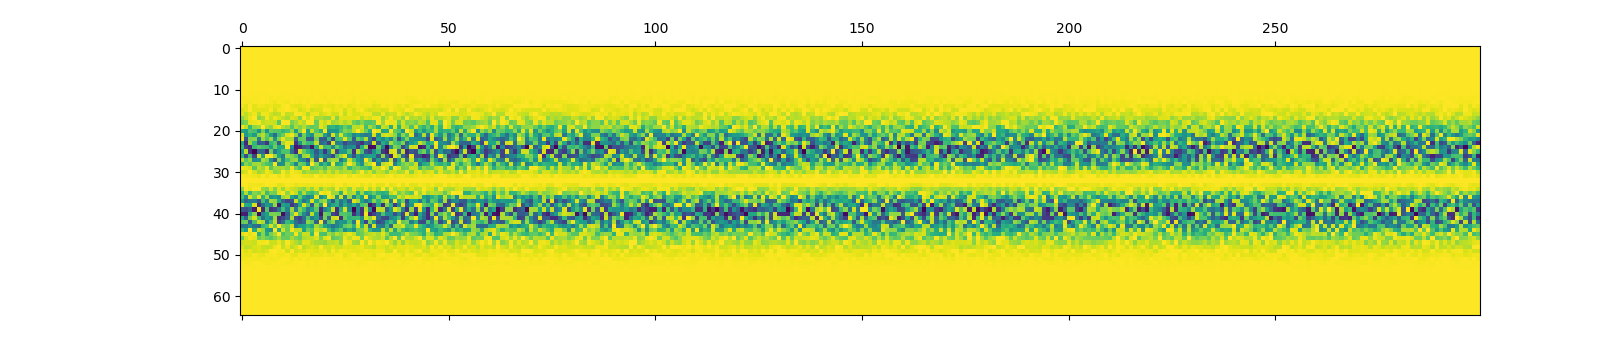

<IPython.core.display.Javascript object>


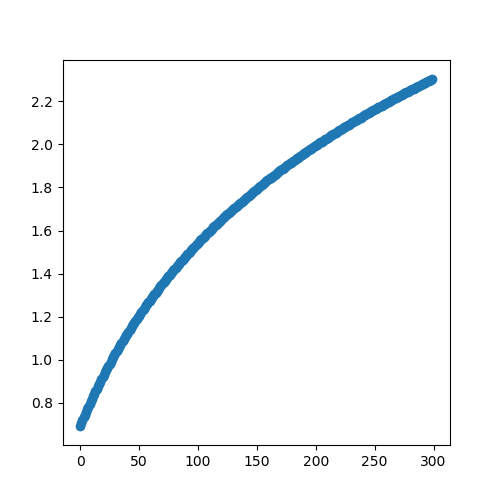

<IPython.core.display.Javascript object>


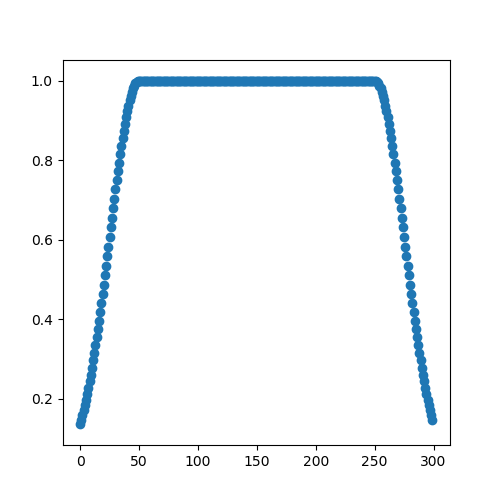

In [233]:
plt.rcParams['figure.figsize'] = [5, 5]

hatGCN = GCN1D(500,
            10,
            20.,
            5.,
            globalTonic=.025,
            tonicGradientX=0,
            stdpWindow=1,
            dt=0.01,
            boostEffect=.5,
            boostDecay=1.,
            placeAlpha=100.,
            decayConstant=.5,
            numPlaces=500,
            learningRate=100.,
            initialWeightFactor=.02,
            boostGradientX=19.5,
            decayGradientX=0.,
            weightDecay=500,
            wideningFactor=2,
            negativeLearnFactorE=.9,
            envelopeWidth=10,
            envelopeFactor=2,
            sigmaLoc=.0005,
            gradientType="exponential",
            envSize=5.,
            weightFunction=mexican_hat,
            normalize=True,
            weightNoise=2.)


inhibGCN = GCN1D(300,
            32,
            1.,
            500.,
            excitationWindow=10,
            excitationCenterBlock=0.,
            globalTonic=2.,
            tonicGradientX=0.,
            stdpWindow=10,
            dt=0.01,
            boostEffect=20.,
            boostDecay=.1,
            activityMeanAlpha=.01,
            placeAlpha=0.01,
            decayConstant=.03,
            numPlaces=500,
            placeMax=.5,
            placeMean=.25,
            learningRate=.005,
            initialWeightFactor=.02,
            boostGradientX=80.,
            decayGradientX=.0,
            weightDecay=1000,
            placeWeightDecay=10000,
            excitatoryWeightDecay=500,
            wideningFactor=0.,
            negativeLearnFactorP=.0,
            negativeLearnFactorE=1.5,
            learnFactorP=100.,
            learnFactorE=1000.,
            envelopeWidth=50,
            envelopeFactor=2,
            sigmaLoc=.01,
            gradientType=1.,
            envSize=5.,
            weightFunction=w_0,
            normalize=False,
            weightNoise=2.)


#GCN.randomLesions(10, 10, 5)
plt.matshow(inhibGCN.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN.boostEffect.shape[0]), np.log(inhibGCN.boostEffect*inhibGCN.alpha))
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN.envelope.shape[0]), inhibGCN.envelope)
plt.show()


In [234]:
plt.rcParams['figure.figsize'] = [5, 5]
for i in range(10):
    print(i)
    inhibGCN.staticLearning(200,
                            logFreq=100000,
                            startFrom = 100.,
                            symmetrize=True)
    

0
1
2
3
4
5
6
7
8
9


In [275]:
for i in range(20):
    print(i)
    inhibGCN.staticLearning(200,
                            logFreq=100000,
                            startFrom = 100.,
                            symmetrize=False)

0
1
2
3
4
5


KeyboardInterrupt: 

In [276]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN.simulate(20,
                                                      logFreq=int(0.01/inhibGCN.dt),
                                                      startFrom = 0.,
                                                      boosting=True)


At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.4
At 8.41
At 8.42
At 8.43
At 8.44
At 8.45
At 8.46
At 8.47
At 8.48
At 8.49
At 8.5
At 8.51
At 8.52
At 8.53
At 8.540000000000001
At 8.55
At 8.56
At 8.57
At 8.58
At 8.59
At 8.6
At 8.61
At 8.620000000000001
At 8.63
At 8.64
At 8.65
At 8.66
At 8.67
At 8.68
At 8.69
At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.

At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.

<IPython.core.display.Javascript object>


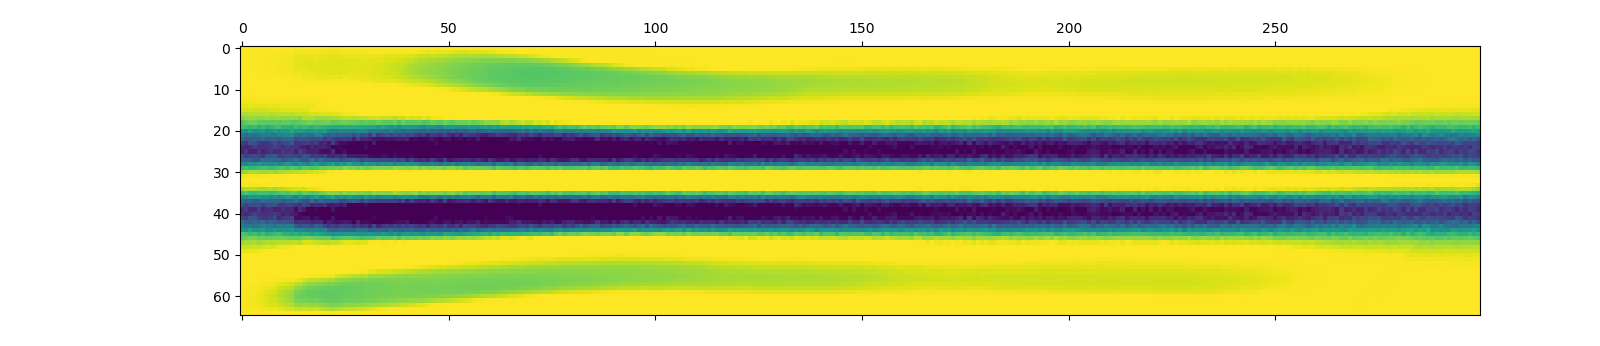

<IPython.core.display.Javascript object>


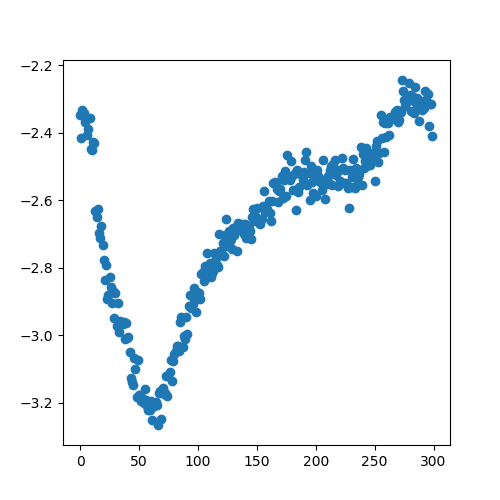

<IPython.core.display.Javascript object>


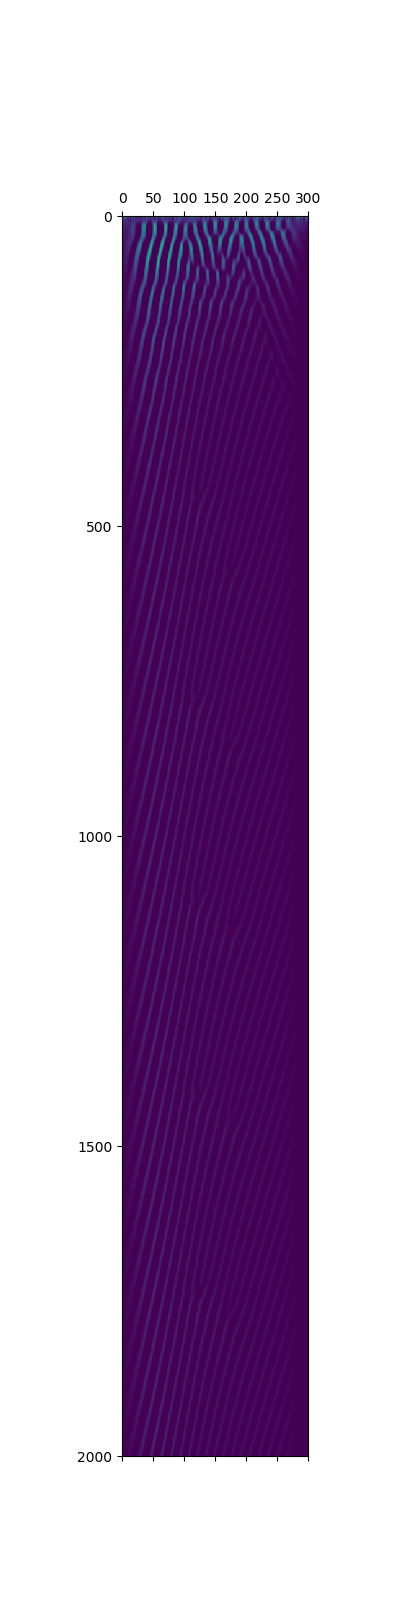

In [277]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN.numX),
            torch.mean(inhibGCN.inhibitoryWeights[0, :], dim=0))
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[:, :])
plt.show()

<IPython.core.display.Javascript object>


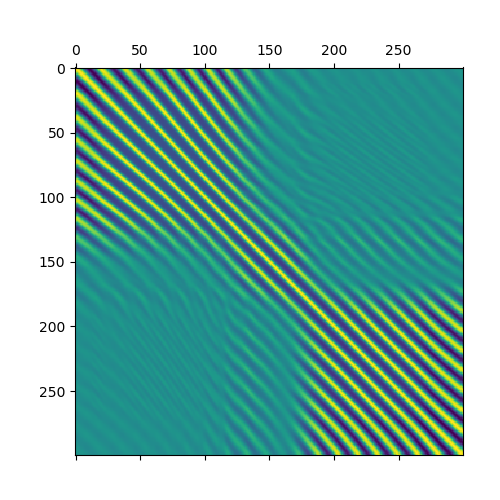

In [278]:
corrs = np.corrcoef(results[-1000:], rowvar=False)
plt.matshow(corrs)

<IPython.core.display.Javascript object>


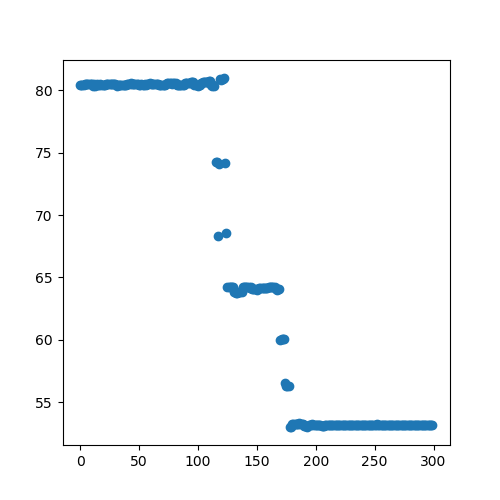

In [279]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(results[-1000:, :]/np.mean(results[-1000:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.show()

In [199]:
with open(os.getcwd() + "\\perfectmodel.pkl", "rb") as f:
    inhibGCN = pkl.load(f)

In [280]:
import pickle as pkl
with open(os.getcwd() + "\\perfectmodel.pkl", "wb") as f:
    pkl.dump(inhibGCN, f)

In [281]:
inhibGCN.placeWeights.fill_(0.)

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [282]:
inhibGCN.placeMax = .1

In [283]:
inhibGCN.learnFactorP

10.0

In [293]:
results = inhibGCN.learn(10,
                          plotting=False,
                          logFreq=(0.01/inhibGCN.dt),
                          speed=1.,
                          preSimulateTime=50,
                          learnInhibitory=False,
                          learnExcitatory=False,
                          simulateTonicBoost=1.)

Starting run 0
tensor(22.1413, device='cuda:0')
tensor(27.0773, device='cuda:0')
tensor(30.9538, device='cuda:0')
tensor(34.7388, device='cuda:0')
tensor(33.5448, device='cuda:0')
tensor(31.0351, device='cuda:0')
tensor(27.7236, device='cuda:0')
tensor(24.9017, device='cuda:0')
tensor(23.0702, device='cuda:0')
tensor(25.4874, device='cuda:0')
tensor(30.8497, device='cuda:0')
tensor(30.3168, device='cuda:0')
tensor(29.1858, device='cuda:0')
tensor(28.1914, device='cuda:0')
tensor(28.0806, device='cuda:0')
tensor(28.5536, device='cuda:0')
tensor(27.5094, device='cuda:0')
tensor(25.7357, device='cuda:0')
tensor(28.0467, device='cuda:0')
tensor(27.8254, device='cuda:0')
tensor(26.6531, device='cuda:0')
tensor(27.8289, device='cuda:0')
tensor(28.0628, device='cuda:0')
tensor(28.3031, device='cuda:0')
tensor(27.7109, device='cuda:0')
tensor(27.6874, device='cuda:0')
tensor(28.4414, device='cuda:0')
tensor(28.1283, device='cuda:0')
tensor(28.8050, device='cuda:0')
tensor(28.3173, device='cuda

tensor(17.2327, device='cuda:0')
tensor(17.9720, device='cuda:0')
tensor(19.8082, device='cuda:0')
tensor(20.0257, device='cuda:0')
tensor(19.1403, device='cuda:0')
tensor(20.6634, device='cuda:0')
tensor(22.0577, device='cuda:0')
tensor(21.8162, device='cuda:0')
tensor(20.5074, device='cuda:0')
tensor(18.7900, device='cuda:0')
tensor(18.9738, device='cuda:0')
tensor(18.8123, device='cuda:0')
tensor(21.6898, device='cuda:0')
tensor(22.9550, device='cuda:0')
tensor(23.2157, device='cuda:0')
tensor(22.4296, device='cuda:0')
tensor(21.0992, device='cuda:0')
tensor(19.5456, device='cuda:0')
tensor(17.9703, device='cuda:0')
tensor(16.4448, device='cuda:0')
tensor(14.9125, device='cuda:0')
tensor(13.3112, device='cuda:0')
tensor(12.7220, device='cuda:0')
tensor(12.4148, device='cuda:0')
tensor(11.7452, device='cuda:0')
tensor(10.7372, device='cuda:0')
tensor(9.3456, device='cuda:0')
tensor(9.6086, device='cuda:0')
tensor(9.8120, device='cuda:0')
tensor(11.3745, device='cuda:0')
tensor(14.607

tensor(31.1836, device='cuda:0')
tensor(31.7892, device='cuda:0')
tensor(31.6781, device='cuda:0')
tensor(31.4882, device='cuda:0')
tensor(32.2442, device='cuda:0')
tensor(31.7538, device='cuda:0')
tensor(31.0889, device='cuda:0')
tensor(32.1585, device='cuda:0')
tensor(31.8103, device='cuda:0')
tensor(30.4569, device='cuda:0')
tensor(30.7152, device='cuda:0')
tensor(30.6771, device='cuda:0')
tensor(30.0303, device='cuda:0')
tensor(29.4186, device='cuda:0')
tensor(30.4424, device='cuda:0')
tensor(30.1671, device='cuda:0')
tensor(29.1006, device='cuda:0')
tensor(31.3577, device='cuda:0')
tensor(32.1879, device='cuda:0')
tensor(31.6452, device='cuda:0')
tensor(32.1758, device='cuda:0')
tensor(33.8749, device='cuda:0')
tensor(33.7047, device='cuda:0')
tensor(32.4615, device='cuda:0')
tensor(32.1901, device='cuda:0')
tensor(33.1055, device='cuda:0')
tensor(32.5183, device='cuda:0')
tensor(30.8617, device='cuda:0')
tensor(31.9439, device='cuda:0')
tensor(32.3576, device='cuda:0')
tensor(31.

tensor(16.8286, device='cuda:0')
tensor(15.5715, device='cuda:0')
tensor(14.3049, device='cuda:0')
tensor(13.0461, device='cuda:0')
tensor(12.5342, device='cuda:0')
tensor(12.7212, device='cuda:0')
tensor(15.2108, device='cuda:0')
tensor(15.5390, device='cuda:0')
tensor(14.1508, device='cuda:0')
tensor(13.5624, device='cuda:0')
tensor(14.2672, device='cuda:0')
tensor(15.7474, device='cuda:0')
tensor(15.8555, device='cuda:0')
tensor(15.2478, device='cuda:0')
tensor(14.4623, device='cuda:0')
tensor(15.5511, device='cuda:0')
tensor(15.4289, device='cuda:0')
tensor(14.5973, device='cuda:0')
tensor(14.7353, device='cuda:0')
tensor(15.4397, device='cuda:0')
tensor(15.2799, device='cuda:0')
tensor(17.5815, device='cuda:0')
tensor(19.2450, device='cuda:0')
tensor(19.4183, device='cuda:0')
tensor(19.2557, device='cuda:0')
tensor(18.0433, device='cuda:0')
tensor(18.3766, device='cuda:0')
tensor(17.7366, device='cuda:0')
tensor(16.5226, device='cuda:0')
tensor(17.0175, device='cuda:0')
tensor(18.

tensor(26.6254, device='cuda:0')
tensor(26.2119, device='cuda:0')
tensor(25.8416, device='cuda:0')
tensor(24.8433, device='cuda:0')
tensor(23.4600, device='cuda:0')
tensor(21.7155, device='cuda:0')
tensor(19.8684, device='cuda:0')
tensor(18.8029, device='cuda:0')
tensor(17.8033, device='cuda:0')
tensor(16.7537, device='cuda:0')
tensor(15.7095, device='cuda:0')
tensor(14.6580, device='cuda:0')
tensor(13.6123, device='cuda:0')
tensor(13.0206, device='cuda:0')
tensor(12.8885, device='cuda:0')
tensor(12.3147, device='cuda:0')
tensor(12.5516, device='cuda:0')
tensor(12.6041, device='cuda:0')
tensor(12.9226, device='cuda:0')
tensor(13.6891, device='cuda:0')
tensor(13.6573, device='cuda:0')
tensor(13.5034, device='cuda:0')
tensor(14.3584, device='cuda:0')
tensor(14.3411, device='cuda:0')
tensor(14.2936, device='cuda:0')
tensor(14.7373, device='cuda:0')
tensor(14.4731, device='cuda:0')
tensor(13.6223, device='cuda:0')
tensor(12.8653, device='cuda:0')
tensor(13.3934, device='cuda:0')
tensor(13.

tensor(18.6956, device='cuda:0')
tensor(17.5212, device='cuda:0')
tensor(18.8593, device='cuda:0')
tensor(19.1226, device='cuda:0')
tensor(18.3670, device='cuda:0')
tensor(18.8824, device='cuda:0')
tensor(19.9966, device='cuda:0')
tensor(19.7490, device='cuda:0')
tensor(19.7538, device='cuda:0')
tensor(20.1142, device='cuda:0')
tensor(19.7719, device='cuda:0')
tensor(21.1501, device='cuda:0')
tensor(21.0247, device='cuda:0')
tensor(20.0374, device='cuda:0')
tensor(20.5689, device='cuda:0')
tensor(20.6261, device='cuda:0')
tensor(19.6966, device='cuda:0')
tensor(20.0221, device='cuda:0')
tensor(20.5980, device='cuda:0')
tensor(19.8943, device='cuda:0')
tensor(19.5355, device='cuda:0')
tensor(20.2262, device='cuda:0')
tensor(19.5376, device='cuda:0')
tensor(18.2167, device='cuda:0')
tensor(16.7219, device='cuda:0')
tensor(15.1180, device='cuda:0')
tensor(13.3202, device='cuda:0')
tensor(11.4445, device='cuda:0')
tensor(10.2937, device='cuda:0')
tensor(9.9757, device='cuda:0')
tensor(10.1

tensor(12.4455, device='cuda:0')
tensor(12.6699, device='cuda:0')
tensor(12.5149, device='cuda:0')
tensor(14.4333, device='cuda:0')
tensor(15.7181, device='cuda:0')
tensor(15.4039, device='cuda:0')
tensor(14.3189, device='cuda:0')
tensor(12.8170, device='cuda:0')
tensor(11.6207, device='cuda:0')
tensor(12.9191, device='cuda:0')
tensor(13.2362, device='cuda:0')
tensor(12.9399, device='cuda:0')
tensor(12.2809, device='cuda:0')
tensor(11.6193, device='cuda:0')
tensor(11.6639, device='cuda:0')
tensor(13.1012, device='cuda:0')
tensor(13.4340, device='cuda:0')
tensor(13.1475, device='cuda:0')
tensor(12.4694, device='cuda:0')
tensor(11.6045, device='cuda:0')
tensor(10.8612, device='cuda:0')
tensor(11.2384, device='cuda:0')
tensor(11.5731, device='cuda:0')
tensor(11.5647, device='cuda:0')
tensor(12.3461, device='cuda:0')
tensor(13.3188, device='cuda:0')
tensor(12.9315, device='cuda:0')
tensor(12.8019, device='cuda:0')
tensor(13.0912, device='cuda:0')
tensor(12.8012, device='cuda:0')
tensor(13.

tensor(11.8721, device='cuda:0')
tensor(10.8199, device='cuda:0')
tensor(9.7086, device='cuda:0')
tensor(9.2444, device='cuda:0')
tensor(9.5199, device='cuda:0')
tensor(9.1594, device='cuda:0')
tensor(8.4673, device='cuda:0')
tensor(8.2630, device='cuda:0')
tensor(8.5153, device='cuda:0')
tensor(8.6785, device='cuda:0')
tensor(8.8300, device='cuda:0')
tensor(8.4987, device='cuda:0')
tensor(8.2379, device='cuda:0')
tensor(8.6589, device='cuda:0')
tensor(8.4724, device='cuda:0')
tensor(8.5832, device='cuda:0')
tensor(8.9613, device='cuda:0')
tensor(8.6788, device='cuda:0')
tensor(9.3732, device='cuda:0')
tensor(10.7640, device='cuda:0')
tensor(10.7741, device='cuda:0')
tensor(10.0938, device='cuda:0')
tensor(11.7659, device='cuda:0')
tensor(11.9383, device='cuda:0')
tensor(11.3381, device='cuda:0')
tensor(10.2877, device='cuda:0')
tensor(9.0935, device='cuda:0')
tensor(8.4837, device='cuda:0')
tensor(7.8578, device='cuda:0')
tensor(7.4219, device='cuda:0')
tensor(7.4699, device='cuda:0')

tensor(11.8609, device='cuda:0')
tensor(11.8328, device='cuda:0')
tensor(10.9543, device='cuda:0')
tensor(9.8184, device='cuda:0')
tensor(12.9312, device='cuda:0')
tensor(14.4793, device='cuda:0')
tensor(14.8099, device='cuda:0')
tensor(14.4940, device='cuda:0')
tensor(13.8352, device='cuda:0')
tensor(12.8336, device='cuda:0')
tensor(11.6838, device='cuda:0')
tensor(10.4530, device='cuda:0')
tensor(9.1389, device='cuda:0')
tensor(8.9918, device='cuda:0')
tensor(9.0383, device='cuda:0')
tensor(9.3058, device='cuda:0')
tensor(9.3669, device='cuda:0')
tensor(9.2451, device='cuda:0')
tensor(11.4088, device='cuda:0')
tensor(11.9262, device='cuda:0')
tensor(11.4479, device='cuda:0')
tensor(10.4612, device='cuda:0')
tensor(9.1953, device='cuda:0')
tensor(9.7962, device='cuda:0')
tensor(9.5741, device='cuda:0')
tensor(8.7779, device='cuda:0')
tensor(8.7561, device='cuda:0')
tensor(9.1086, device='cuda:0')
tensor(9.1016, device='cuda:0')
tensor(8.7268, device='cuda:0')
tensor(9.0404, device='cu

tensor(14.1501, device='cuda:0')
tensor(13.9219, device='cuda:0')
tensor(13.5849, device='cuda:0')
tensor(13.1809, device='cuda:0')
tensor(12.5984, device='cuda:0')
tensor(11.9365, device='cuda:0')
tensor(11.2003, device='cuda:0')
tensor(10.4615, device='cuda:0')
tensor(9.5764, device='cuda:0')
tensor(8.6348, device='cuda:0')
tensor(8.1606, device='cuda:0')
tensor(7.6140, device='cuda:0')
tensor(7.2934, device='cuda:0')
tensor(7.2027, device='cuda:0')
tensor(9.8975, device='cuda:0')
tensor(11.3976, device='cuda:0')
tensor(11.4954, device='cuda:0')
tensor(10.8498, device='cuda:0')
tensor(9.7835, device='cuda:0')
tensor(8.5661, device='cuda:0')
tensor(8.3830, device='cuda:0')
tensor(8.3231, device='cuda:0')
tensor(8.1488, device='cuda:0')
tensor(7.8659, device='cuda:0')
tensor(7.4055, device='cuda:0')
tensor(7.0997, device='cuda:0')
tensor(6.9525, device='cuda:0')
tensor(6.7385, device='cuda:0')
tensor(6.6081, device='cuda:0')
tensor(6.5670, device='cuda:0')
tensor(6.4219, device='cuda:0

tensor(9.2889, device='cuda:0')
tensor(9.3930, device='cuda:0')
tensor(8.7506, device='cuda:0')
tensor(7.8744, device='cuda:0')
tensor(7.8300, device='cuda:0')
tensor(7.8179, device='cuda:0')
tensor(7.8263, device='cuda:0')
tensor(7.4881, device='cuda:0')
tensor(9.4367, device='cuda:0')
tensor(11.7973, device='cuda:0')
tensor(12.3912, device='cuda:0')
tensor(11.9695, device='cuda:0')
tensor(12.4337, device='cuda:0')
tensor(13.6134, device='cuda:0')
tensor(13.4142, device='cuda:0')
tensor(12.5309, device='cuda:0')
tensor(12.3544, device='cuda:0')
tensor(13.3389, device='cuda:0')
tensor(13.0735, device='cuda:0')
tensor(12.0599, device='cuda:0')
tensor(10.6983, device='cuda:0')
tensor(9.1903, device='cuda:0')
tensor(8.3428, device='cuda:0')
tensor(10.3171, device='cuda:0')
tensor(13.0579, device='cuda:0')
tensor(13.7886, device='cuda:0')
tensor(13.3237, device='cuda:0')
tensor(12.2817, device='cuda:0')
tensor(11.0364, device='cuda:0')
tensor(9.7022, device='cuda:0')
tensor(10.3892, device

tensor(7.8864, device='cuda:0')
tensor(7.6221, device='cuda:0')
tensor(7.1817, device='cuda:0')
tensor(6.9270, device='cuda:0')
tensor(6.7860, device='cuda:0')
tensor(6.7177, device='cuda:0')
tensor(6.5398, device='cuda:0')
tensor(6.3727, device='cuda:0')
tensor(6.2997, device='cuda:0')
tensor(6.6753, device='cuda:0')
tensor(8.5999, device='cuda:0')
tensor(10.8942, device='cuda:0')
tensor(11.6091, device='cuda:0')
tensor(11.2991, device='cuda:0')
tensor(10.4663, device='cuda:0')
tensor(9.4435, device='cuda:0')
tensor(8.3369, device='cuda:0')
tensor(7.4128, device='cuda:0')
tensor(7.1828, device='cuda:0')
tensor(7.0273, device='cuda:0')
tensor(7.1194, device='cuda:0')
tensor(6.9643, device='cuda:0')
tensor(6.5712, device='cuda:0')
tensor(6.3451, device='cuda:0')
tensor(5.9355, device='cuda:0')
tensor(5.3197, device='cuda:0')
tensor(4.4149, device='cuda:0')
tensor(3.2538, device='cuda:0')
tensor(1.9525, device='cuda:0')
Starting run 6
tensor(22.4871, device='cuda:0')
tensor(29.2462, devi

tensor(8.9877, device='cuda:0')
tensor(9.8397, device='cuda:0')
tensor(11.8402, device='cuda:0')
tensor(12.5471, device='cuda:0')
tensor(12.4337, device='cuda:0')
tensor(11.5528, device='cuda:0')
tensor(10.2469, device='cuda:0')
tensor(8.6905, device='cuda:0')
tensor(8.0403, device='cuda:0')
tensor(7.6107, device='cuda:0')
tensor(7.2101, device='cuda:0')
tensor(7.3527, device='cuda:0')
tensor(8.1670, device='cuda:0')
tensor(13.4152, device='cuda:0')
tensor(15.1878, device='cuda:0')
tensor(14.1844, device='cuda:0')
tensor(11.5536, device='cuda:0')
tensor(16.1381, device='cuda:0')
tensor(17.3749, device='cuda:0')
tensor(16.5975, device='cuda:0')
tensor(18.5646, device='cuda:0')
tensor(19.3767, device='cuda:0')
tensor(19.2169, device='cuda:0')
tensor(18.9764, device='cuda:0')
tensor(18.9020, device='cuda:0')
tensor(18.1974, device='cuda:0')
tensor(16.6994, device='cuda:0')
tensor(17.7946, device='cuda:0')
tensor(17.3677, device='cuda:0')
tensor(16.7090, device='cuda:0')
tensor(17.0237, de

tensor(21.9149, device='cuda:0')
tensor(27.7283, device='cuda:0')
tensor(30.5488, device='cuda:0')
tensor(30.6757, device='cuda:0')
tensor(28.8770, device='cuda:0')
tensor(26.1740, device='cuda:0')
tensor(29.4979, device='cuda:0')
tensor(27.9221, device='cuda:0')
tensor(25.5926, device='cuda:0')
tensor(22.2874, device='cuda:0')
tensor(22.8581, device='cuda:0')
tensor(23.9875, device='cuda:0')
tensor(27.2828, device='cuda:0')
tensor(29.0278, device='cuda:0')
tensor(29.2009, device='cuda:0')
tensor(29.9689, device='cuda:0')
tensor(30.4322, device='cuda:0')
tensor(33.1478, device='cuda:0')
tensor(33.1111, device='cuda:0')
tensor(31.5133, device='cuda:0')
tensor(29.3549, device='cuda:0')
tensor(28.2605, device='cuda:0')
tensor(27.9212, device='cuda:0')
tensor(28.6606, device='cuda:0')
tensor(29.0549, device='cuda:0')
tensor(28.1938, device='cuda:0')
tensor(28.8843, device='cuda:0')
tensor(28.8942, device='cuda:0')
tensor(28.0719, device='cuda:0')
tensor(29.9692, device='cuda:0')
tensor(30.

tensor(19.1505, device='cuda:0')
tensor(19.6933, device='cuda:0')
tensor(19.1466, device='cuda:0')
tensor(19.1562, device='cuda:0')
tensor(18.1138, device='cuda:0')
tensor(16.8955, device='cuda:0')
tensor(17.7395, device='cuda:0')
tensor(17.0604, device='cuda:0')
tensor(16.6305, device='cuda:0')
tensor(16.6561, device='cuda:0')
tensor(16.0516, device='cuda:0')
tensor(16.7067, device='cuda:0')
tensor(16.7495, device='cuda:0')
tensor(16.9939, device='cuda:0')
tensor(16.9438, device='cuda:0')
tensor(16.0413, device='cuda:0')
tensor(16.5959, device='cuda:0')
tensor(16.4273, device='cuda:0')
tensor(15.4444, device='cuda:0')
tensor(15.5210, device='cuda:0')
tensor(15.5267, device='cuda:0')
tensor(14.6459, device='cuda:0')
tensor(15.2312, device='cuda:0')
tensor(15.0680, device='cuda:0')
tensor(14.7550, device='cuda:0')
tensor(15.0534, device='cuda:0')
tensor(14.5329, device='cuda:0')
tensor(15.1365, device='cuda:0')
tensor(18.1963, device='cuda:0')
tensor(19.8039, device='cuda:0')
tensor(19.

tensor(28.0818, device='cuda:0')
tensor(27.7498, device='cuda:0')
tensor(28.0589, device='cuda:0')
tensor(28.1822, device='cuda:0')
tensor(28.4380, device='cuda:0')
tensor(29.0921, device='cuda:0')
tensor(29.0676, device='cuda:0')
tensor(29.1436, device='cuda:0')
tensor(29.5013, device='cuda:0')
tensor(29.3079, device='cuda:0')
tensor(28.4566, device='cuda:0')
tensor(28.6983, device='cuda:0')
tensor(28.6950, device='cuda:0')
tensor(28.0003, device='cuda:0')
tensor(26.7706, device='cuda:0')
tensor(25.1066, device='cuda:0')
tensor(24.3108, device='cuda:0')
tensor(22.9496, device='cuda:0')
tensor(22.4265, device='cuda:0')
tensor(23.1344, device='cuda:0')
tensor(23.1015, device='cuda:0')
tensor(22.4794, device='cuda:0')
tensor(23.1828, device='cuda:0')
tensor(25.7641, device='cuda:0')
tensor(26.8637, device='cuda:0')
tensor(27.0485, device='cuda:0')
tensor(26.3919, device='cuda:0')
tensor(25.8780, device='cuda:0')
tensor(25.7967, device='cuda:0')
tensor(25.2291, device='cuda:0')
tensor(24.

tensor(14.7436, device='cuda:0')
tensor(15.4017, device='cuda:0')
tensor(19.3519, device='cuda:0')
tensor(20.2059, device='cuda:0')
tensor(19.2167, device='cuda:0')
tensor(17.3142, device='cuda:0')
tensor(15.3825, device='cuda:0')
tensor(15.4919, device='cuda:0')
tensor(14.9197, device='cuda:0')
tensor(15.0564, device='cuda:0')
tensor(14.7004, device='cuda:0')
tensor(14.7800, device='cuda:0')
tensor(14.2696, device='cuda:0')
tensor(14.6164, device='cuda:0')
tensor(16.3228, device='cuda:0')
tensor(17.3030, device='cuda:0')
tensor(17.2059, device='cuda:0')
tensor(16.2238, device='cuda:0')
tensor(14.8813, device='cuda:0')
tensor(16.0610, device='cuda:0')
tensor(16.1222, device='cuda:0')
tensor(15.5645, device='cuda:0')
tensor(14.7399, device='cuda:0')
tensor(13.5958, device='cuda:0')
tensor(13.1149, device='cuda:0')
tensor(12.3633, device='cuda:0')
tensor(11.3484, device='cuda:0')
tensor(11.1180, device='cuda:0')
tensor(14.8812, device='cuda:0')
tensor(16.6315, device='cuda:0')
tensor(17.

tensor(22.5145, device='cuda:0')
tensor(21.7325, device='cuda:0')
tensor(20.7016, device='cuda:0')
tensor(19.4850, device='cuda:0')
tensor(18.0719, device='cuda:0')
tensor(16.5723, device='cuda:0')
tensor(15.6308, device='cuda:0')
tensor(14.9902, device='cuda:0')
tensor(14.2381, device='cuda:0')
tensor(13.4552, device='cuda:0')
tensor(12.6517, device='cuda:0')
tensor(11.8784, device='cuda:0')
tensor(12.0927, device='cuda:0')
tensor(11.8415, device='cuda:0')
tensor(12.7747, device='cuda:0')
tensor(12.2476, device='cuda:0')
tensor(11.5015, device='cuda:0')
tensor(11.5976, device='cuda:0')
tensor(12.0918, device='cuda:0')
tensor(12.1375, device='cuda:0')
tensor(11.6883, device='cuda:0')
tensor(12.2664, device='cuda:0')
tensor(12.4566, device='cuda:0')
tensor(12.4603, device='cuda:0')
tensor(12.9669, device='cuda:0')
tensor(12.8497, device='cuda:0')
tensor(12.2646, device='cuda:0')
tensor(11.8367, device='cuda:0')
tensor(12.0937, device='cuda:0')
tensor(12.2406, device='cuda:0')
tensor(12.

tensor(18.0241, device='cuda:0')
tensor(18.8389, device='cuda:0')
tensor(18.6958, device='cuda:0')
tensor(20.0568, device='cuda:0')
tensor(20.4592, device='cuda:0')
tensor(20.0076, device='cuda:0')
tensor(19.5184, device='cuda:0')
tensor(20.3473, device='cuda:0')
tensor(20.0073, device='cuda:0')
tensor(19.1949, device='cuda:0')
tensor(18.0451, device='cuda:0')
tensor(18.3866, device='cuda:0')
tensor(18.4633, device='cuda:0')
tensor(17.9371, device='cuda:0')
tensor(17.0093, device='cuda:0')
tensor(17.3104, device='cuda:0')
tensor(17.2493, device='cuda:0')
tensor(16.4770, device='cuda:0')
tensor(16.3291, device='cuda:0')
tensor(16.9958, device='cuda:0')
tensor(16.7653, device='cuda:0')
tensor(15.9920, device='cuda:0')
tensor(17.2940, device='cuda:0')
tensor(17.7133, device='cuda:0')
tensor(17.2640, device='cuda:0')
tensor(17.1755, device='cuda:0')
tensor(17.2769, device='cuda:0')
tensor(16.6070, device='cuda:0')
tensor(17.2430, device='cuda:0')
tensor(17.1091, device='cuda:0')
tensor(16.

<IPython.core.display.Javascript object>


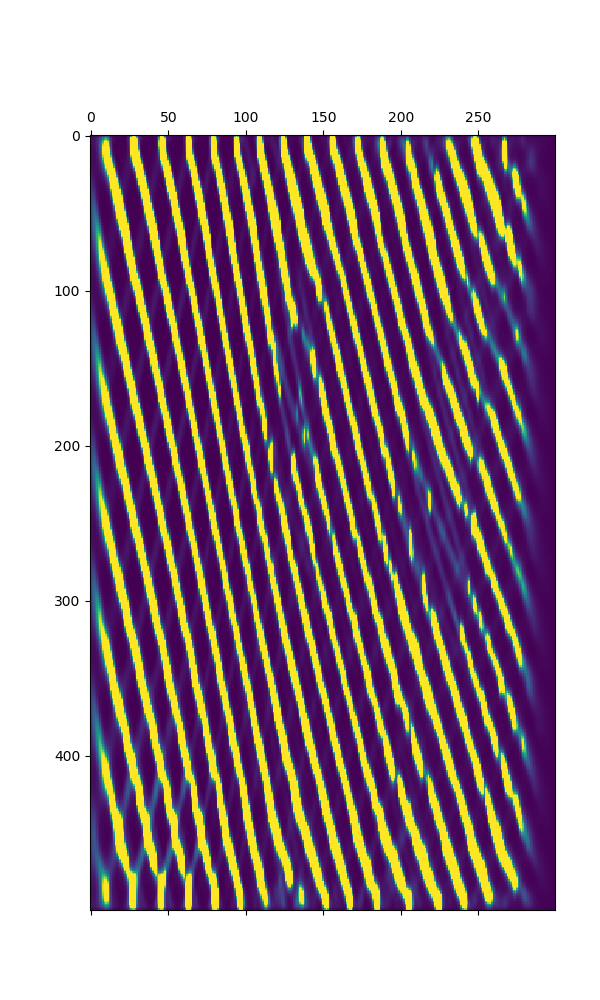

In [294]:
plt.matshow(torch.transpose(inhibGCN.placeWeights, 0, 1))

<IPython.core.display.Javascript object>


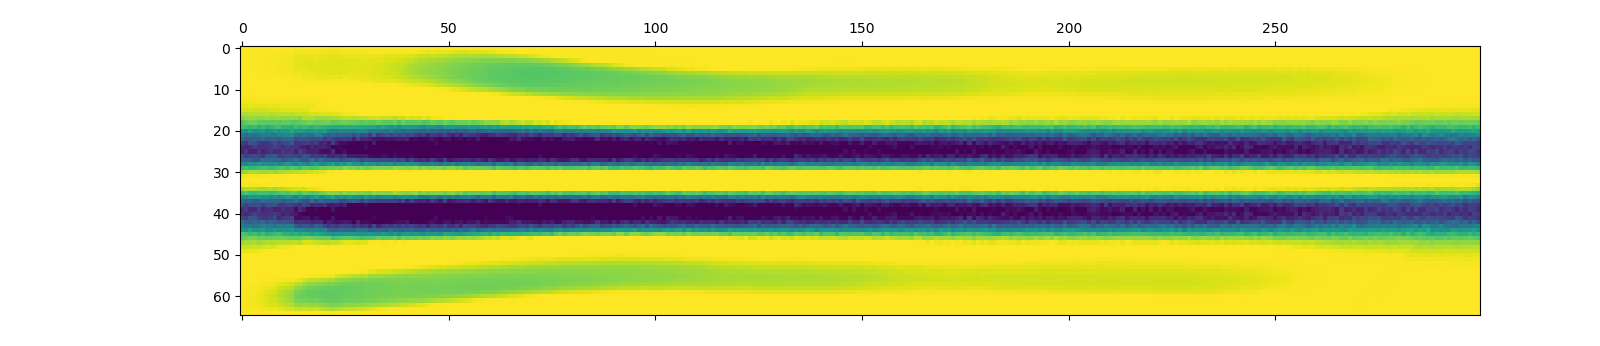

<IPython.core.display.Javascript object>


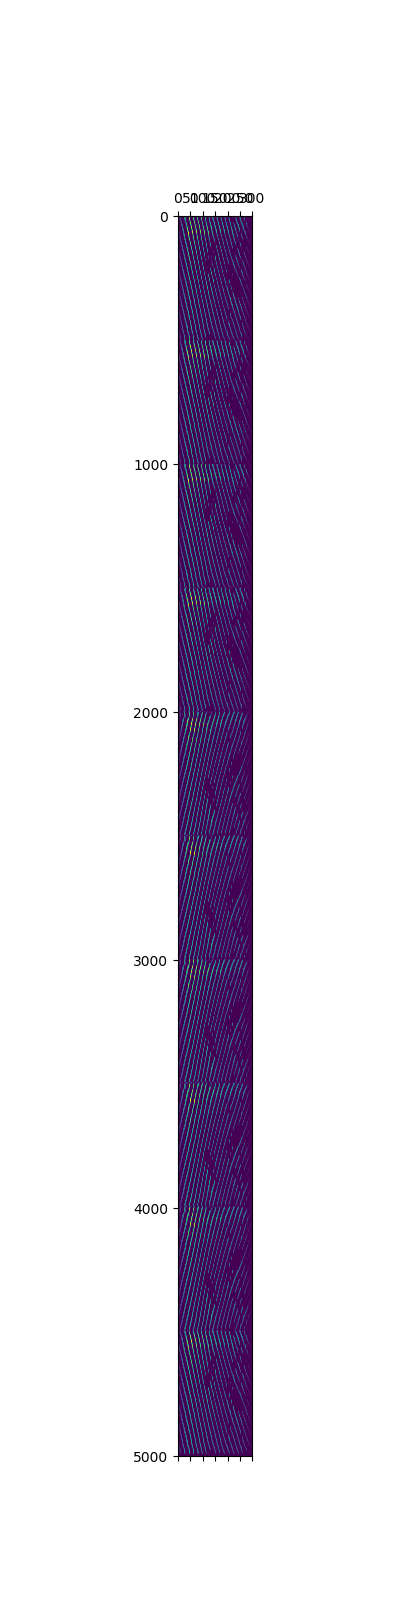

In [295]:
plt.matshow(inhibGCN.inhibitoryWeights[0])
plt.matshow(results)

<IPython.core.display.Javascript object>


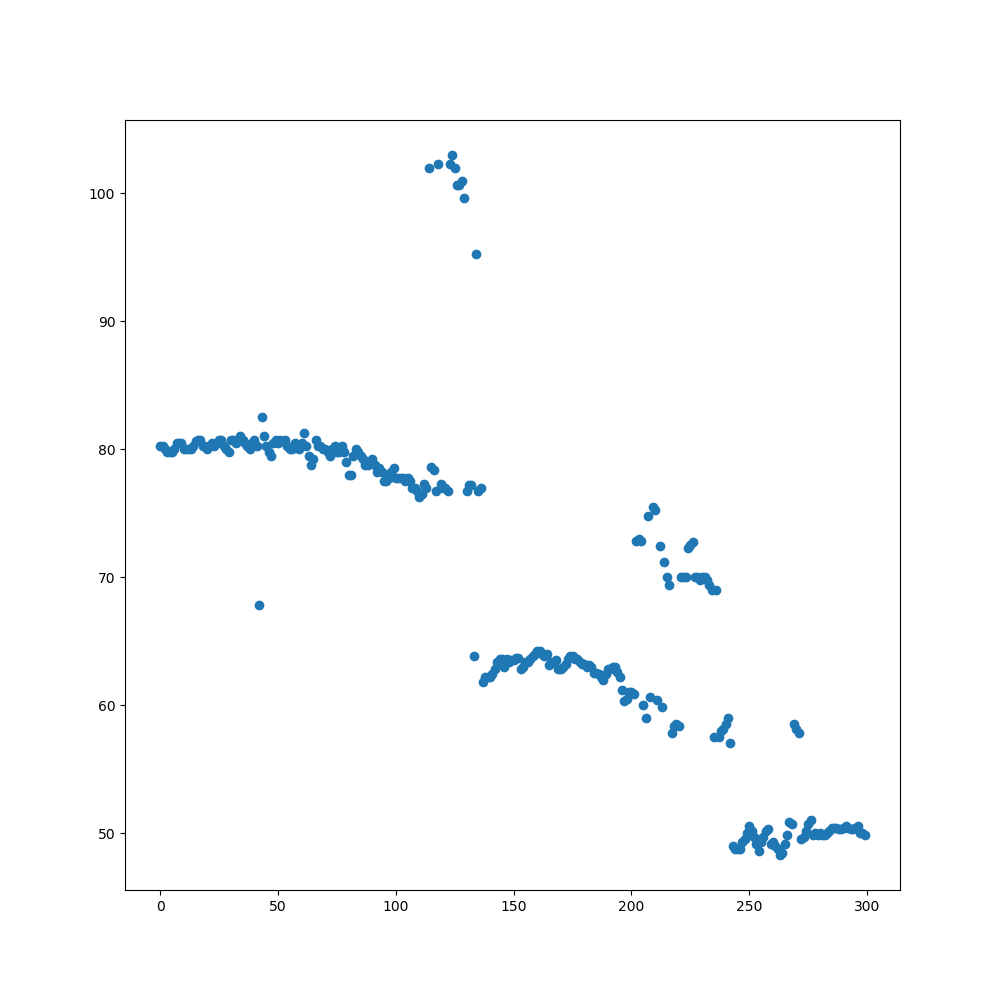

In [296]:
plt.rcParams['figure.figsize'] = [10, 10]
mat = torch.transpose(inhibGCN.placeWeights, 0, 1).cpu().numpy()
activityScales = compute_scales(mat[50:-50, :]/np.mean(mat[50:-50, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.show()

<IPython.core.display.Javascript object>


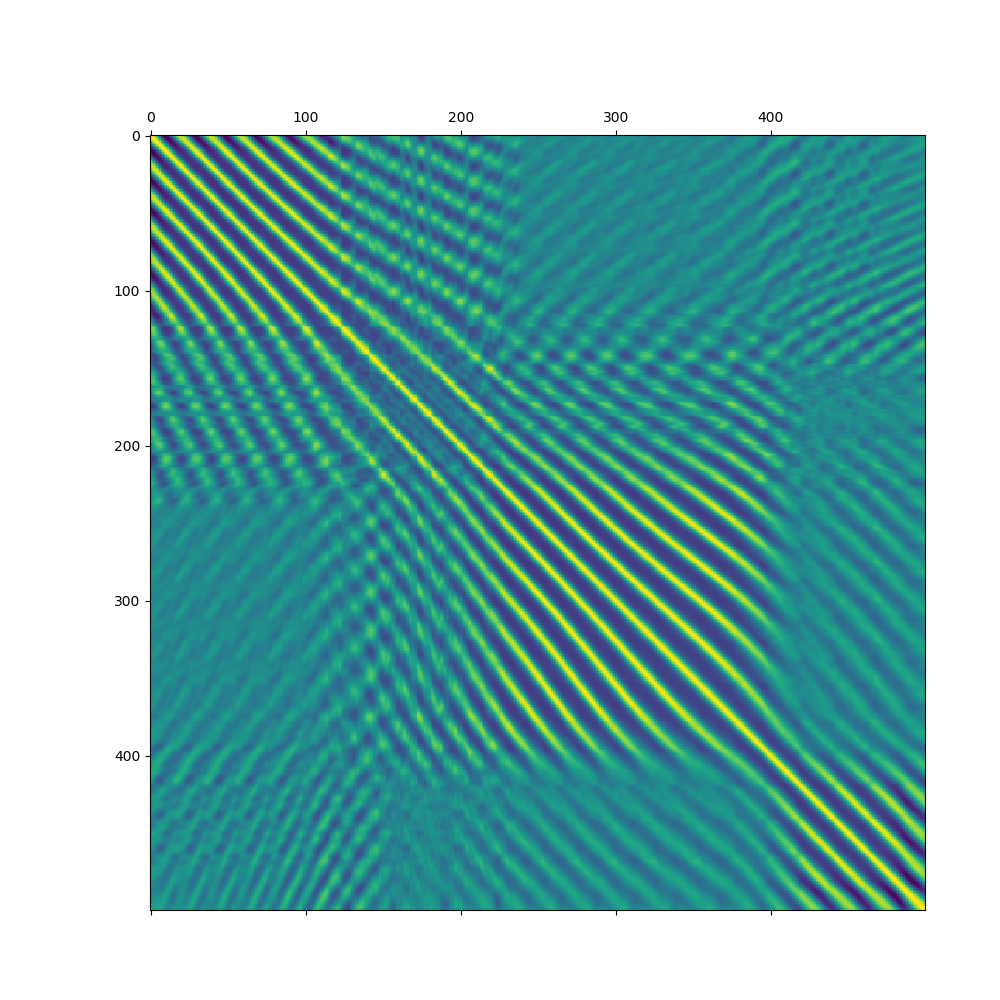

In [60]:
corrs = np.corrcoef(inhibGCN.placeWeights, rowvar=True)
plt.matshow(corrs)

In [75]:
inhibGCN.negativeLearnFactorE = 1.

In [9]:
inhibGCN.excitatoryWeightDecay = 500000000000

In [10]:
inhibGCN.placeWeights *= 10

In [58]:
inhibGCN.learnFactorE = 20

In [15]:
inhibGCN.excitationMask.fill_(1.)

tensor([[[ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.],
         [ 1.]]], device='cuda:0')

In [83]:
results = inhibGCN.learn(50,
                          preSimulateTime=5.,
                          plotting=False,
                          logFreq=(0.01/inhibGCN.dt),
                          speed=1.,
                          learnInhibitory=False,
                          learnExcitatory=True,
                          learnPlace=False,
                          useExcitatory=True,
                          boosting=False,
                          learnStart=1.)

Starting run 0
Starting run 1
Starting run 2
Starting run 3
Starting run 4
Starting run 5
Starting run 6
Starting run 7
Starting run 8
Starting run 9
Starting run 10
Starting run 11
Starting run 12
Starting run 13
Starting run 14
Starting run 15
Starting run 16
Starting run 17
Starting run 18
Starting run 19
Starting run 20
Starting run 21
Starting run 22
Starting run 23
Starting run 24
Starting run 25
Starting run 26
Starting run 27
Starting run 28
Starting run 29
Starting run 30
Starting run 31
Starting run 32
Starting run 33
Starting run 34
Starting run 35
Starting run 36
Starting run 37
Starting run 38
Starting run 39
Starting run 40
Starting run 41
Starting run 42
Starting run 43
Starting run 44
Starting run 45
Starting run 46
Starting run 47
Starting run 48
Starting run 49


In [77]:
inhibGCN.excitatoryWeights["s"] = inhibGCN2.excitatoryWeights["s"]
inhibGCN.excitatoryWeights["n"] = inhibGCN2.excitatoryWeights["n"]
inhibGCN.excitationMask = inhibGCN2.excitationMask
inhibGCN.excitatoryKernel = inhibGCN2.excitatoryKernel

In [33]:
inhibGCN.envelope = inhibGCN2.envelope

<IPython.core.display.Javascript object>


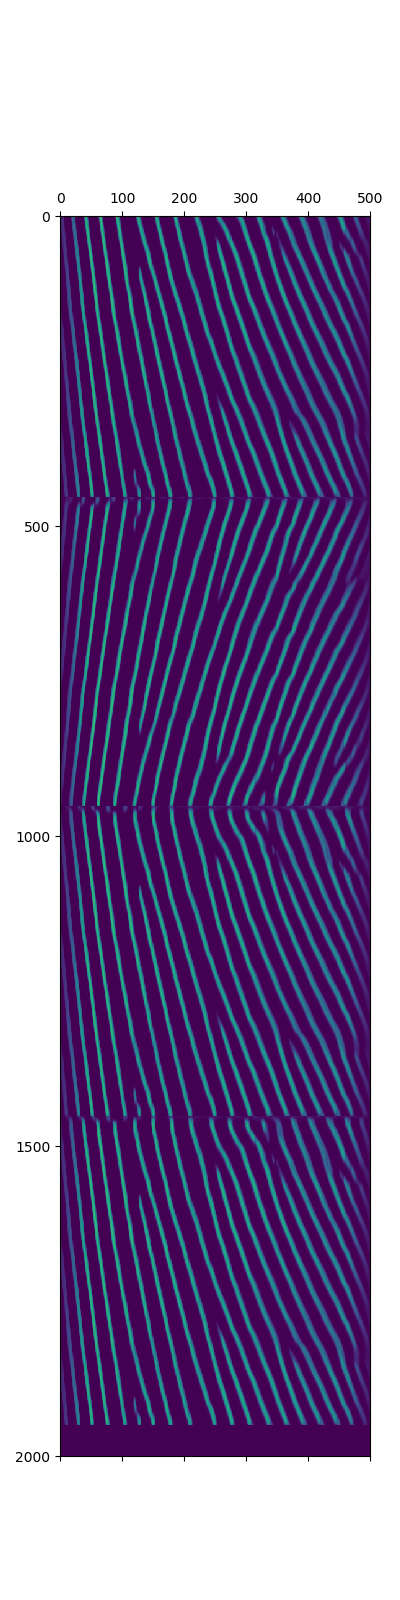

<IPython.core.display.Javascript object>


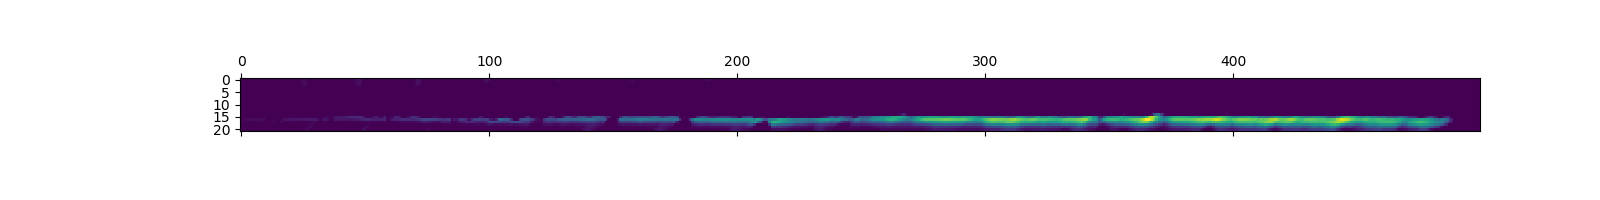

<IPython.core.display.Javascript object>


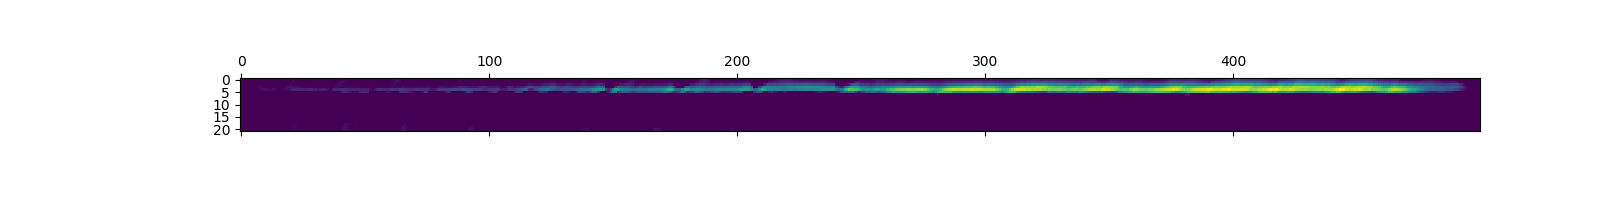

In [84]:
plt.matshow(results[-2000:], vmax=1, vmin=0)
plt.matshow(inhibGCN.excitatoryWeights["s"][0])
plt.matshow(inhibGCN.excitatoryWeights["n"][0])

In [ ]:
inhibGCN.normalize=False

In [85]:
plt.rcParams['figure.figsize'] = [5, 5]
simresults, simhistResults, siminstResults = inhibGCN.simulate(100,
                                                      logFreq=int(0.01/inhibGCN.dt),
                                                      startFrom = 0.,
                                                      vel=-1.,
                                                      boosting=True)

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.540000000000001
At 9.55
At 9.56
At 9.57
At 9.58
At 9.59
At 9.6
At 9.61
At 9.620000000000001
At 9.63
At 9.64
At 9.65
At 9.66
At 9.67
At 9.68
At 9.69
At 9.700000000000001
At 9.71
At 9.72
At 9.73
At 9.74
At 9.75
At 9.76
At 9.77
At 9.78
At 9.790000000000001
At 9.8
At 9.81
At 9.82
At 9.83
At 9.84
At 9.85
At 9.86
At 9.870000000000001
At 9.88
At 9.89
At 9.9
At 9.91
At 9.92
At 9.93
At 9.94
At 9.950000000000001
At 9.96
At 9.97
At 9.98
At 9.99
At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 

At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At 17.84
At 17.85
At 17.86
At 17.87
At 17.88
At 17.89
At 17.9000000000000

At 24.79
At 24.8
At 24.810000000000002
At 24.82
At 24.830000000000002
At 24.84
At 24.85
At 24.86
At 24.87
At 24.88
At 24.89
At 24.900000000000002
At 24.91
At 24.92
At 24.93
At 24.94
At 24.95
At 24.96
At 24.97
At 24.98
At 24.990000000000002
At 25.0
At 25.01
At 25.02
At 25.03
At 25.04
At 25.05
At 25.060000000000002
At 25.07
At 25.080000000000002
At 25.09
At 25.1
At 25.11
At 25.12
At 25.13
At 25.14
At 25.150000000000002
At 25.16
At 25.17
At 25.18
At 25.19
At 25.2
At 25.21
At 25.22
At 25.23
At 25.240000000000002
At 25.25
At 25.26
At 25.27
At 25.28
At 25.29
At 25.3
At 25.310000000000002
At 25.32
At 25.330000000000002
At 25.34
At 25.35
At 25.36
At 25.37
At 25.38
At 25.39
At 25.400000000000002
At 25.41
At 25.42
At 25.43
At 25.44
At 25.45
At 25.46
At 25.47
At 25.48
At 25.490000000000002
At 25.5
At 25.51
At 25.52
At 25.53
At 25.54
At 25.55
At 25.560000000000002
At 25.57
At 25.580000000000002
At 25.59
At 25.6
At 25.61
At 25.62
At 25.63
At 25.64
At 25.650000000000002
At 25.66
At 25.67
At 25.68
At

At 32.93
At 32.94
At 32.95
At 32.96
At 32.97
At 32.980000000000004
At 32.99
At 33.0
At 33.01
At 33.02
At 33.03
At 33.04
At 33.05
At 33.06
At 33.07
At 33.08
At 33.09
At 33.1
At 33.11
At 33.12
At 33.13
At 33.14
At 33.15
At 33.160000000000004
At 33.17
At 33.18
At 33.19
At 33.2
At 33.21
At 33.22
At 33.230000000000004
At 33.24
At 33.25
At 33.26
At 33.27
At 33.28
At 33.29
At 33.3
At 33.31
At 33.32
At 33.33
At 33.34
At 33.35
At 33.36
At 33.37
At 33.38
At 33.39
At 33.4
At 33.410000000000004
At 33.42
At 33.43
At 33.44
At 33.45
At 33.46
At 33.47
At 33.480000000000004
At 33.49
At 33.5
At 33.51
At 33.52
At 33.53
At 33.54
At 33.55
At 33.56
At 33.57
At 33.58
At 33.59
At 33.6
At 33.61
At 33.62
At 33.63
At 33.64
At 33.65
At 33.660000000000004
At 33.67
At 33.68
At 33.69
At 33.7
At 33.71
At 33.72
At 33.730000000000004
At 33.74
At 33.75
At 33.76
At 33.77
At 33.78
At 33.79
At 33.8
At 33.81
At 33.82
At 33.83
At 33.84
At 33.85
At 33.86
At 33.87
At 33.88
At 33.89
At 33.9
At 33.910000000000004
At 33.92
At 33.

At 41.03
At 41.04
At 41.050000000000004
At 41.06
At 41.07
At 41.08
At 41.09
At 41.1
At 41.11
At 41.12
At 41.13
At 41.14
At 41.15
At 41.160000000000004
At 41.17
At 41.18
At 41.19
At 41.2
At 41.21
At 41.22
At 41.230000000000004
At 41.24
At 41.25
At 41.26
At 41.27
At 41.28
At 41.29
At 41.300000000000004
At 41.31
At 41.32
At 41.33
At 41.34
At 41.35
At 41.36
At 41.37
At 41.38
At 41.39
At 41.4
At 41.410000000000004
At 41.42
At 41.43
At 41.44
At 41.45
At 41.46
At 41.47
At 41.480000000000004
At 41.49
At 41.5
At 41.51
At 41.52
At 41.53
At 41.54
At 41.550000000000004
At 41.56
At 41.57
At 41.58
At 41.59
At 41.6
At 41.61
At 41.62
At 41.63
At 41.64
At 41.65
At 41.660000000000004
At 41.67
At 41.68
At 41.69
At 41.7
At 41.71
At 41.72
At 41.730000000000004
At 41.74
At 41.75
At 41.76
At 41.77
At 41.78
At 41.79
At 41.800000000000004
At 41.81
At 41.82
At 41.83
At 41.84
At 41.85
At 41.86
At 41.87
At 41.88
At 41.89
At 41.9
At 41.910000000000004
At 41.92
At 41.93
At 41.94
At 41.95
At 41.96
At 41.97
At 41.980

At 49.07
At 49.08
At 49.09
At 49.1
At 49.11
At 49.120000000000005
At 49.13
At 49.14
At 49.15
At 49.160000000000004
At 49.17
At 49.18
At 49.19
At 49.2
At 49.21
At 49.22
At 49.230000000000004
At 49.24
At 49.25
At 49.26
At 49.27
At 49.28
At 49.29
At 49.300000000000004
At 49.31
At 49.32
At 49.33
At 49.34
At 49.35
At 49.36
At 49.370000000000005
At 49.38
At 49.39
At 49.4
At 49.410000000000004
At 49.42
At 49.43
At 49.44
At 49.45
At 49.46
At 49.47
At 49.480000000000004
At 49.49
At 49.5
At 49.51
At 49.52
At 49.53
At 49.54
At 49.550000000000004
At 49.56
At 49.57
At 49.58
At 49.59
At 49.6
At 49.61
At 49.620000000000005
At 49.63
At 49.64
At 49.65
At 49.660000000000004
At 49.67
At 49.68
At 49.69
At 49.7
At 49.71
At 49.72
At 49.730000000000004
At 49.74
At 49.75
At 49.76
At 49.77
At 49.78
At 49.79
At 49.800000000000004
At 49.81
At 49.82
At 49.83
At 49.84
At 49.85
At 49.86
At 49.870000000000005
At 49.88
At 49.89
At 49.9
At 49.910000000000004
At 49.92
At 49.93
At 49.94
At 49.95
At 49.96
At 49.97
At 49.

At 57.01
At 57.02
At 57.03
At 57.04
At 57.050000000000004
At 57.06
At 57.07
At 57.08
At 57.09
At 57.1
At 57.11
At 57.120000000000005
At 57.13
At 57.14
At 57.15
At 57.160000000000004
At 57.17
At 57.18
At 57.19
At 57.2
At 57.21
At 57.22
At 57.230000000000004
At 57.24
At 57.25
At 57.26
At 57.27
At 57.28
At 57.29
At 57.300000000000004
At 57.31
At 57.32
At 57.33
At 57.34
At 57.35
At 57.36
At 57.370000000000005
At 57.38
At 57.39
At 57.4
At 57.410000000000004
At 57.42
At 57.43
At 57.44
At 57.45
At 57.46
At 57.47
At 57.480000000000004
At 57.49
At 57.5
At 57.51
At 57.52
At 57.53
At 57.54
At 57.550000000000004
At 57.56
At 57.57
At 57.58
At 57.59
At 57.6
At 57.61
At 57.620000000000005
At 57.63
At 57.64
At 57.65
At 57.660000000000004
At 57.67
At 57.68
At 57.69
At 57.7
At 57.71
At 57.72
At 57.730000000000004
At 57.74
At 57.75
At 57.76
At 57.77
At 57.78
At 57.79
At 57.800000000000004
At 57.81
At 57.82
At 57.83
At 57.84
At 57.85
At 57.86
At 57.870000000000005
At 57.88
At 57.89
At 57.9
At 57.910000000

At 64.43
At 64.44
At 64.45
At 64.46000000000001
At 64.47
At 64.48
At 64.49
At 64.5
At 64.51
At 64.52
At 64.53
At 64.54
At 64.55
At 64.56
At 64.57000000000001
At 64.58
At 64.59
At 64.6
At 64.61
At 64.62
At 64.63
At 64.64
At 64.65
At 64.66
At 64.67
At 64.68
At 64.69
At 64.7
At 64.71000000000001
At 64.72
At 64.73
At 64.74
At 64.75
At 64.76
At 64.77
At 64.78
At 64.79
At 64.8
At 64.81
At 64.82000000000001
At 64.83
At 64.84
At 64.85
At 64.86
At 64.87
At 64.88
At 64.89
At 64.9
At 64.91
At 64.92
At 64.93
At 64.94
At 64.95
At 64.96000000000001
At 64.97
At 64.98
At 64.99
At 65.0
At 65.01
At 65.02
At 65.03
At 65.04
At 65.05
At 65.06
At 65.07000000000001
At 65.08
At 65.09
At 65.1
At 65.11
At 65.12
At 65.13
At 65.14
At 65.15
At 65.16
At 65.17
At 65.18
At 65.19
At 65.2
At 65.21000000000001
At 65.22
At 65.23
At 65.24
At 65.25
At 65.26
At 65.27
At 65.28
At 65.29
At 65.3
At 65.31
At 65.32000000000001
At 65.33
At 65.34
At 65.35
At 65.36
At 65.37
At 65.38
At 65.39
At 65.4
At 65.41
At 65.42
At 65.43
At 65

At 72.54
At 72.55
At 72.56
At 72.57000000000001
At 72.58
At 72.59
At 72.60000000000001
At 72.61
At 72.62
At 72.63
At 72.64
At 72.65
At 72.66
At 72.67
At 72.68
At 72.69
At 72.7
At 72.71000000000001
At 72.72
At 72.73
At 72.74
At 72.75
At 72.76
At 72.77
At 72.78
At 72.79
At 72.8
At 72.81
At 72.82000000000001
At 72.83
At 72.84
At 72.85000000000001
At 72.86
At 72.87
At 72.88
At 72.89
At 72.9
At 72.91
At 72.92
At 72.93
At 72.94
At 72.95
At 72.96000000000001
At 72.97
At 72.98
At 72.99
At 73.0
At 73.01
At 73.02
At 73.03
At 73.04
At 73.05
At 73.06
At 73.07000000000001
At 73.08
At 73.09
At 73.10000000000001
At 73.11
At 73.12
At 73.13
At 73.14
At 73.15
At 73.16
At 73.17
At 73.18
At 73.19
At 73.2
At 73.21000000000001
At 73.22
At 73.23
At 73.24
At 73.25
At 73.26
At 73.27
At 73.28
At 73.29
At 73.3
At 73.31
At 73.32000000000001
At 73.33
At 73.34
At 73.35000000000001
At 73.36
At 73.37
At 73.38
At 73.39
At 73.4
At 73.41
At 73.42
At 73.43
At 73.44
At 73.45
At 73.46000000000001
At 73.47
At 73.48
At 73.49

At 81.16
At 81.17
At 81.18
At 81.19
At 81.2
At 81.21000000000001
At 81.22
At 81.23
At 81.24
At 81.25
At 81.26
At 81.27
At 81.28
At 81.29
At 81.3
At 81.31
At 81.32000000000001
At 81.33
At 81.34
At 81.35000000000001
At 81.36
At 81.37
At 81.38
At 81.39
At 81.4
At 81.41
At 81.42
At 81.43
At 81.44
At 81.45
At 81.46000000000001
At 81.47
At 81.48
At 81.49
At 81.5
At 81.51
At 81.52
At 81.53
At 81.54
At 81.55
At 81.56
At 81.57000000000001
At 81.58
At 81.59
At 81.60000000000001
At 81.61
At 81.62
At 81.63
At 81.64
At 81.65
At 81.66
At 81.67
At 81.68
At 81.69
At 81.7
At 81.71000000000001
At 81.72
At 81.73
At 81.74
At 81.75
At 81.76
At 81.77
At 81.78
At 81.79
At 81.8
At 81.81
At 81.82000000000001
At 81.83
At 81.84
At 81.85000000000001
At 81.86
At 81.87
At 81.88
At 81.89
At 81.9
At 81.91
At 81.92
At 81.93
At 81.94
At 81.95
At 81.96000000000001
At 81.97
At 81.98
At 81.99
At 82.0
At 82.01
At 82.02
At 82.03
At 82.04
At 82.05
At 82.06
At 82.07000000000001
At 82.08
At 82.09
At 82.10000000000001
At 82.11


At 89.5
At 89.51
At 89.52
At 89.53
At 89.54
At 89.55
At 89.56
At 89.57000000000001
At 89.58
At 89.59
At 89.60000000000001
At 89.61
At 89.62
At 89.63
At 89.64
At 89.65
At 89.66
At 89.67
At 89.68
At 89.69
At 89.7
At 89.71000000000001
At 89.72
At 89.73
At 89.74
At 89.75
At 89.76
At 89.77
At 89.78
At 89.79
At 89.8
At 89.81
At 89.82000000000001
At 89.83
At 89.84
At 89.85000000000001
At 89.86
At 89.87
At 89.88
At 89.89
At 89.9
At 89.91
At 89.92
At 89.93
At 89.94
At 89.95
At 89.96000000000001
At 89.97
At 89.98
At 89.99
At 90.0
At 90.01
At 90.02
At 90.03
At 90.04
At 90.05
At 90.06
At 90.07000000000001
At 90.08
At 90.09
At 90.10000000000001
At 90.11
At 90.12
At 90.13
At 90.14
At 90.15
At 90.16
At 90.17
At 90.18
At 90.19
At 90.2
At 90.21000000000001
At 90.22
At 90.23
At 90.24
At 90.25
At 90.26
At 90.27
At 90.28
At 90.29
At 90.3
At 90.31
At 90.32000000000001
At 90.33
At 90.34
At 90.35000000000001
At 90.36
At 90.37
At 90.38
At 90.39
At 90.4
At 90.41
At 90.42
At 90.43
At 90.44
At 90.45
At 90.460000

At 97.94
At 97.95
At 97.96000000000001
At 97.97
At 97.98
At 97.99000000000001
At 98.0
At 98.01
At 98.02
At 98.03
At 98.04
At 98.05
At 98.06
At 98.07000000000001
At 98.08
At 98.09
At 98.10000000000001
At 98.11
At 98.12
At 98.13
At 98.14
At 98.15
At 98.16
At 98.17
At 98.18
At 98.19
At 98.2
At 98.21000000000001
At 98.22
At 98.23
At 98.24000000000001
At 98.25
At 98.26
At 98.27
At 98.28
At 98.29
At 98.3
At 98.31
At 98.32000000000001
At 98.33
At 98.34
At 98.35000000000001
At 98.36
At 98.37
At 98.38
At 98.39
At 98.4
At 98.41
At 98.42
At 98.43
At 98.44
At 98.45
At 98.46000000000001
At 98.47
At 98.48
At 98.49000000000001
At 98.5
At 98.51
At 98.52
At 98.53
At 98.54
At 98.55
At 98.56
At 98.57000000000001
At 98.58
At 98.59
At 98.60000000000001
At 98.61
At 98.62
At 98.63
At 98.64
At 98.65
At 98.66
At 98.67
At 98.68
At 98.69
At 98.7
At 98.71000000000001
At 98.72
At 98.73
At 98.74000000000001
At 98.75
At 98.76
At 98.77
At 98.78
At 98.79
At 98.8
At 98.81
At 98.82000000000001
At 98.83
At 98.84
At 98.85

<IPython.core.display.Javascript object>


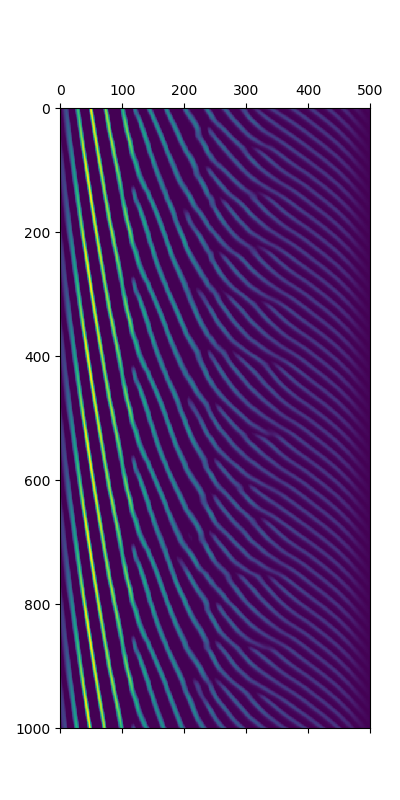

In [86]:
plt.matshow(simresults[-1000:, :])

<IPython.core.display.Javascript object>


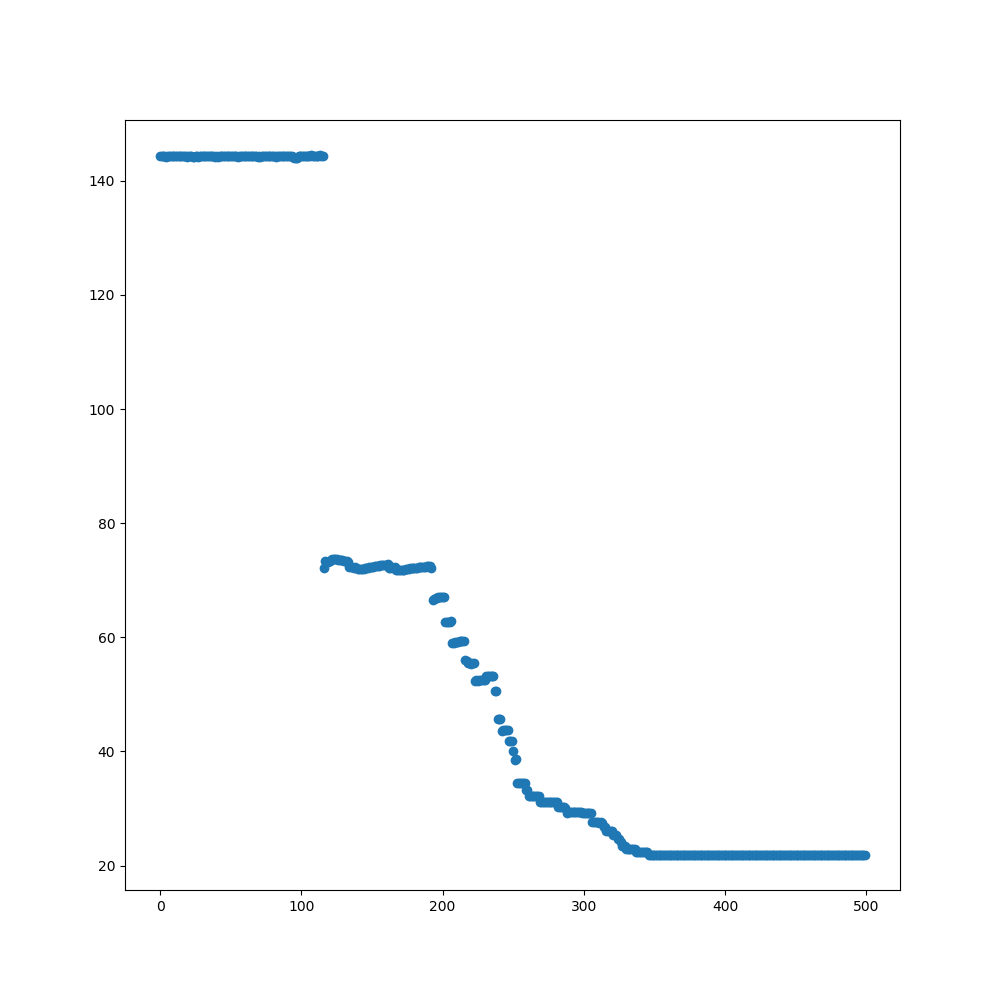

In [87]:
plt.rcParams['figure.figsize'] = [10, 10]
activityScales = compute_scales(simresults[-1000:, :]/np.mean(simresults[-1000:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.show()

In [15]:
inhibGCN.activityMeanAlpha *= 10

<IPython.core.display.Javascript object>


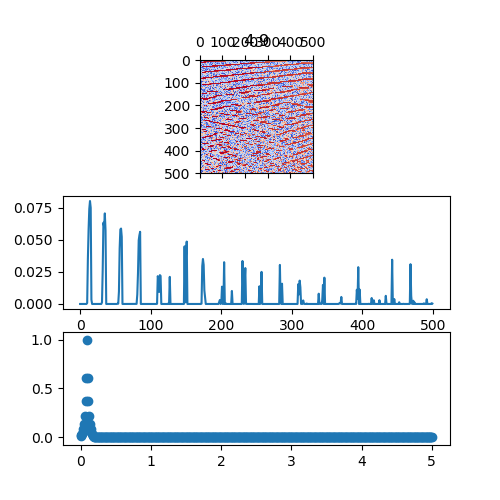

Starting run 0


UnboundLocalError: local variable 'output' referenced before assignment

In [61]:
plt.rcParams['figure.figsize'] = [5, 5]
inhibGCN.learn(1, plotting=True, plotInterval=10, speed=1., preSimulateTime=50.)

<IPython.core.display.Javascript object>


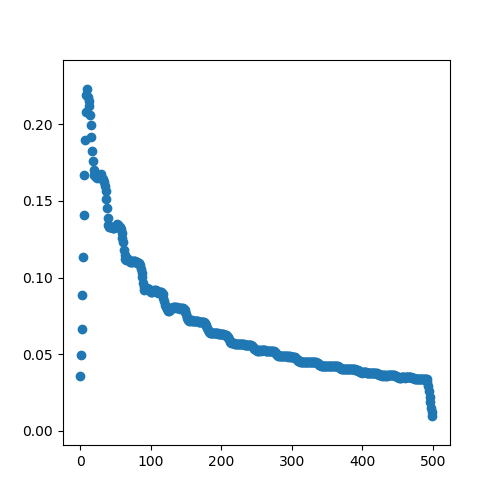

In [17]:
plt.figure()
plt.scatter(np.arange(inhibGCN.longHistory.shape[-1]), inhibGCN.longHistory[0, 0])
plt.show()

In [ ]:
alphas = np.asarray([20,
                    10,
                    15,
                    5,
                    20,
                    20,
                    10,
                    15,
                    40,
                    40,
                    10,
                    5,
                    5,
                    40,
                    15,
                    0.5,
                    5.,
                    2.,
                    1.,
                    1.,
                    ])

boostEffects = np.asarray([100,
                          200,
                          200,
                          200,
                          200,
                          400,
                          100,
                          100,
                          100,
                          400,
                          400,
                          100,
                          400,
                          200,
                          400,
                          50,
                          50.,
                          50.,
                          50.,
                          400.,
                          ])

scales = np.asarray([43.75,
                    37.3,
                    30,
                    60,
                    21.6,
                    14.5,
                    74,
                    55,
                    33.5,
                    9,
                    23,
                    106.5,
                    34.5,
                    15,
                    17.5,
                    700,
                    150.,
                    282.,
                    400.,
                    103.,
                    ])


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(1./(alphas)**.7,
                       1./(boostEffects)**.7,
                       scales,
                       linewidth=0,
                       #cmap=cm.coolwarm,
                       antialiased=True)


ax.set_xlabel("Moving average constant")
ax.set_ylabel("Boost effect")
ax.set_zlabel("Scale")
plt.title("Scale vs. boosting")

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


ax.view_init(15, 210)
plt.savefig("ScaleSurface.png", dpi = 250)
plt.draw()
plt.show()

In [ ]:
combinations = (1./(alphas/0.001) * 1./boostEffects)**0.7

plt.figure()
fit = np.polyfit(combinations,scales,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.scatter(combinations, scales)
plt.plot(combinations, fit_fn(combinations), '--k',
         label = "y = {0:4.3f}x + {1:4.3f}".format(fit_fn[1], fit_fn[0]))
plt.legend(loc="best")
plt.show()

In [ ]:
weights = torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy()
placeScales = compute_scales(weights[:, :]/np.max(weights[:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(placeScales.shape[0]), placeScales)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.gca()
smoothed = smooth(placeScales,window_len=5, window="flat")
ax.scatter(np.arange(smoothed.shape[0]), smoothed)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Scales')
ax1.set_ylabel('Scale (cm)', color=color)
ax1.scatter(np.arange(GCN.numX), 1./placeScales, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Boost effect (negative square root)', color=color)  # we already handled the x-label with ax1
ax2.scatter(np.arange(GCN.numX), np.power(GCN.boostEffect, 1/2.), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [ ]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
np.min(results)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", .01)

<video controls src="./test.mp4" />